In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
import re
import string
import nltk
import unicodedata
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aparra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aparra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
import re
import nltk

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aparra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Detección de idioma
from langdetect import detect


In [5]:
import stanza

stanza.download('es')
nlp = stanza.Pipeline('es') 

2022-09-23 14:43:00 INFO: Downloading default packages for language: es (Spanish)...
2022-09-23 14:43:01 INFO: File exists: C:\Users\aparra\stanza_resources\es\default.zip
2022-09-23 14:43:04 INFO: Finished downloading models and saved to C:\Users\aparra\stanza_resources.


2022-09-23 14:43:05 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-09-23 14:43:05 INFO: Use device: cpu
2022-09-23 14:43:05 INFO: Loading: tokenize
2022-09-23 14:43:05 INFO: Loading: mwt
2022-09-23 14:43:05 INFO: Loading: pos
2022-09-23 14:43:06 INFO: Loading: lemma
2022-09-23 14:43:06 INFO: Loading: depparse
2022-09-23 14:43:06 INFO: Loading: ner
2022-09-23 14:43:07 INFO: Done loading processors!


In [6]:
# Carga de datos de archivo .csv

csv_path = 'data_quejas.csv'
base = pd.read_csv(csv_path, sep=';')
base.head()

motivo medioingreso            momento                      razon  \
0  Queja      Llamada  Después del vuelo    Irregularidad Equipajes   
1  Queja      Llamada    Antes del vuelo  Irregularidad Operacional   
2  Queja      Llamada   Durante el vuelo  Servicios complementarios   
3  Queja      Llamada  Después del vuelo  Irregularidad Operacional   
4  Queja      Digital    Antes del vuelo        Consultas generales   

                                         descripcion  
0  o senhor victor cunha entra em contato indican...  
1  pasajero solicita se le brinde nuevamente su n...  
2  nos contacta karla cruz para generar un reclam...  
3  se comunica el cliente para utilizar emd custo...  
4  el dia de hoy tenia un vuelo saliendo de la ci...

In [7]:
def idioma(text):
    valor=''
    try:
        valor=detect(text)
    except:
        valor='na'
    return valor

In [8]:
base['lang'] = base['descripcion'].apply(idioma)
base.head()

motivo medioingreso            momento                      razon  \
0  Queja      Llamada  Después del vuelo    Irregularidad Equipajes   
1  Queja      Llamada    Antes del vuelo  Irregularidad Operacional   
2  Queja      Llamada   Durante el vuelo  Servicios complementarios   
3  Queja      Llamada  Después del vuelo  Irregularidad Operacional   
4  Queja      Digital    Antes del vuelo        Consultas generales   

                                         descripcion lang  
0  o senhor victor cunha entra em contato indican...   pt  
1  pasajero solicita se le brinde nuevamente su n...   es  
2  nos contacta karla cruz para generar un reclam...   es  
3  se comunica el cliente para utilizar emd custo...   es  
4  el dia de hoy tenia un vuelo saliendo de la ci...   es

In [9]:
# Filtrado de mensajes en español
base = base[base['lang'] == 'es']
base.shape

(9013, 6)

In [10]:
## Analisis de comentarios: Ejem
base.iloc[26]["descripcion"]

'buenas tardes\nsr aerolinea\n\nno pude viajar el 19 nov 2018 al viaje que tenia programado por quebrantos de salud, era para presentar la excusa medica para la exoneración de  la penalidad del tiquete que tengo emitido con ustedes numero de boleto 1112486052259 que esta mi nombre\n\nruta bogota miami bogota.\n\nno tengo  la nueva fecha de viaje pero es para ir adelantando la exoneracion de la penalidad'

In [11]:
### Limpieza de datos

def preprocessor(text):
    
    text=re.sub("\W+"," ",str(text)) # caracteres especiales
    text=re.sub(" \d+", " ",str(text)) # eliminar numeros  
    text=text.lower() ##Texto a minusculas
    text = re.sub(r'^https?:\/\/.*[\r\n]*',"", str(text), flags=re.MULTILINE) ##Eliminar URL
    text=unicodedata.normalize("NFKD", text).encode("ascii","ignore").decode("ascii") ## Eliminar tildes
    
    ##Eliminar emojis
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text=re.sub(emoj,"", str(text))
    text=text.strip() ## Eliminar espacios adelante y atras de un texto
    tokenized_list = nltk.word_tokenize(text) ## tokenizacion
    stop_words=set(stopwords.words('spanish')) 
    cleaned_list=[i for i in tokenized_list if i not in stop_words]# remover stop words
    text = [i for i in cleaned_list if len(i) > 3]  ## Eliminar las palabras con menos de 3 letras
    text = [re.sub("\S*(\S*([a-zA-Z]\S*[0-9])|([0-9]\S*[a-zA-Z]))\S*", " ", i) for i in text]
    text = ['correo' if bool(re.search("\S*@\S*\s?", i)) else i for i in text]
    text = [i for i in text if i not in ["correo"," "]]
    text = [re.sub("[^\\w\\s]|\\n|\n ", " ", i) for i in text]
    text = [re.sub("enero"," ",i) for i in text]
    return ' '.join(text)


In [12]:
base['descripcion_limpia'] = base['descripcion'].apply(preprocessor)
base

motivo            medioingreso            momento  \
1     Queja                 Llamada    Antes del vuelo   
2     Queja                 Llamada   Durante el vuelo   
3     Queja                 Llamada  Después del vuelo   
4     Queja                 Digital    Antes del vuelo   
5     Queja                 Llamada  Después del vuelo   
...     ...                     ...                ...   
9994  Queja  Libro de reclamaciones    Antes del vuelo   
9995  Queja      Correo electrónico    Antes del vuelo   
9996  Queja                 Llamada  Después del vuelo   
9997  Queja                 Llamada  Después del vuelo   
9999  Queja      Correo electrónico  Después del vuelo   

                          razon  \
1     Irregularidad Operacional   
2     Servicios complementarios   
3     Irregularidad Operacional   
4           Consultas generales   
5       Irregularidad Equipajes   
...                         ...   
9994  Irregularidad Operacional   
9995  Irregularidad Operacional   
9996    Irregularidad Equipajes   
9997    Irregularidad Equipajes   
9999    Irregularidad Equipajes   

                                            descripcion lang  \
1     pasajero solicita se le brinde nuevamente su n...   es   
2     nos contacta karla cruz para generar un reclam...   es   
3     se comunica el cliente para utilizar emd custo...   es   
4     el dia de hoy tenia un vuelo saliendo de la ci...   es   
5     se contacta la señora carmen, solicita verific...   es   
...                                                 ...  ...   
9994  pasajera afectada por la cancelación del vuelo...   es   
9995  compre un vuelo que salia a las 21.52 hrs desd...   es   
9996  indica marzena que aun no tienen informacion d...   es   
9997  se comunica la sra. ana maria calderon solicit...   es   
9999  se crea caso para dejar registro del saqueo,  ...   es   

                                     descripcion_limpia  
1     pasajero solicita brinde nuevamente numero com...  
2     contacta karla cruz generar reclamo pasajero j...  
3     comunica cliente utilizar customer service com...  
4     tenia vuelo saliendo ciudad monteria ddestino ...  
5     contacta senora carmen solicita verificar caso...  
...                                                 ...  
9994  pasajera afectada cancelacion vuelo debido cli...  
9995  compre vuelo salia bogota chile adquirir ticke...  
9996                  indica marzena informacion maleta  
9997  comunica maria calderon solicitando informacio...  
9999    crea caso dejar registro saqueo maneja radicado  

[9013 rows x 7 columns]

In [13]:
base['descripcion_limpia'] = base['descripcion'].apply(preprocessor)
base

motivo            medioingreso            momento  \
1     Queja                 Llamada    Antes del vuelo   
2     Queja                 Llamada   Durante el vuelo   
3     Queja                 Llamada  Después del vuelo   
4     Queja                 Digital    Antes del vuelo   
5     Queja                 Llamada  Después del vuelo   
...     ...                     ...                ...   
9994  Queja  Libro de reclamaciones    Antes del vuelo   
9995  Queja      Correo electrónico    Antes del vuelo   
9996  Queja                 Llamada  Después del vuelo   
9997  Queja                 Llamada  Después del vuelo   
9999  Queja      Correo electrónico  Después del vuelo   

                          razon  \
1     Irregularidad Operacional   
2     Servicios complementarios   
3     Irregularidad Operacional   
4           Consultas generales   
5       Irregularidad Equipajes   
...                         ...   
9994  Irregularidad Operacional   
9995  Irregularidad Operacional   
9996    Irregularidad Equipajes   
9997    Irregularidad Equipajes   
9999    Irregularidad Equipajes   

                                            descripcion lang  \
1     pasajero solicita se le brinde nuevamente su n...   es   
2     nos contacta karla cruz para generar un reclam...   es   
3     se comunica el cliente para utilizar emd custo...   es   
4     el dia de hoy tenia un vuelo saliendo de la ci...   es   
5     se contacta la señora carmen, solicita verific...   es   
...                                                 ...  ...   
9994  pasajera afectada por la cancelación del vuelo...   es   
9995  compre un vuelo que salia a las 21.52 hrs desd...   es   
9996  indica marzena que aun no tienen informacion d...   es   
9997  se comunica la sra. ana maria calderon solicit...   es   
9999  se crea caso para dejar registro del saqueo,  ...   es   

                                     descripcion_limpia  
1     pasajero solicita brinde nuevamente numero com...  
2     contacta karla cruz generar reclamo pasajero j...  
3     comunica cliente utilizar customer service com...  
4     tenia vuelo saliendo ciudad monteria ddestino ...  
5     contacta senora carmen solicita verificar caso...  
...                                                 ...  
9994  pasajera afectada cancelacion vuelo debido cli...  
9995  compre vuelo salia bogota chile adquirir ticke...  
9996                  indica marzena informacion maleta  
9997  comunica maria calderon solicitando informacio...  
9999    crea caso dejar registro saqueo maneja radicado  

[9013 rows x 7 columns]

In [14]:
base["descripcion_limpia"].iloc[26]

'buenas tardes aerolinea pude viajar viaje tenia programado quebrantos salud presentar excusa medica exoneracion penalidad tiquete emitido ustedes numero boleto nombre ruta bogota miami bogota nueva fecha viaje adelantando exoneracion penalidad'

In [15]:
base["descripcion_limpia"].apply(lambda x: len(str(x).split(" "))).describe()

count    9013.000000
mean       40.768113
std        74.688347
min         1.000000
25%         9.000000
50%        21.000000
75%        46.000000
max      1492.000000
Name: descripcion_limpia, dtype: float64

In [16]:
np.quantile(base["descripcion_limpia"].apply(lambda x: len(str(x).split(" "))),0.9)

87.0

In [17]:
np.quantile(base["descripcion_limpia"].apply(lambda x: len(str(x).split(" "))),0.1)

5.0

In [18]:
base=base[base["descripcion_limpia"].apply(lambda x: len(str(x).split(" ")))<=87]
base=base[base["descripcion_limpia"].apply(lambda x: len(str(x).split(" ")))>=5]

In [19]:
base["descripcion_limpia"].apply(lambda x: len(str(x).split(" "))).describe()

count    7424.000000
mean       26.708513
std        20.535513
min         5.000000
25%        10.000000
50%        20.000000
75%        39.000000
max        87.000000
Name: descripcion_limpia, dtype: float64

In [20]:
# Tokenización
from nltk.tokenize import word_tokenize
base['tkn'] = base['descripcion_limpia'].apply(word_tokenize)
base['tkn'].head()

1    [pasajero, solicita, brinde, nuevamente, numer...
2    [contacta, karla, cruz, generar, reclamo, pasa...
3    [comunica, cliente, utilizar, customer, servic...
4    [tenia, vuelo, saliendo, ciudad, monteria, dde...
5    [contacta, senora, carmen, solicita, verificar...
Name: tkn, dtype: object

In [21]:
##Lematizacion
base["lemma"]=0

for i in range(0,base["descripcion_limpia"].shape[0]):
    lista=[]
    doc = nlp(base["descripcion_limpia"].iloc[i])
    for sent in doc.sentences:
        for word in sent.words:
            lista.append(word.lemma)
    base["lemma"].iloc[i]=lista
base

motivo            medioingreso            momento  \
1     Queja                 Llamada    Antes del vuelo   
2     Queja                 Llamada   Durante el vuelo   
3     Queja                 Llamada  Después del vuelo   
4     Queja                 Digital    Antes del vuelo   
5     Queja                 Llamada  Después del vuelo   
...     ...                     ...                ...   
9993  Queja                 Digital    Antes del vuelo   
9994  Queja  Libro de reclamaciones    Antes del vuelo   
9995  Queja      Correo electrónico    Antes del vuelo   
9997  Queja                 Llamada  Después del vuelo   
9999  Queja      Correo electrónico  Después del vuelo   

                          razon  \
1     Irregularidad Operacional   
2     Servicios complementarios   
3     Irregularidad Operacional   
4           Consultas generales   
5       Irregularidad Equipajes   
...                         ...   
9993  Irregularidad Operacional   
9994  Irregularidad Operacional   
9995  Irregularidad Operacional   
9997    Irregularidad Equipajes   
9999    Irregularidad Equipajes   

                                            descripcion lang  \
1     pasajero solicita se le brinde nuevamente su n...   es   
2     nos contacta karla cruz para generar un reclam...   es   
3     se comunica el cliente para utilizar emd custo...   es   
4     el dia de hoy tenia un vuelo saliendo de la ci...   es   
5     se contacta la señora carmen, solicita verific...   es   
...                                                 ...  ...   
9993  reclamación previa a acciones legales caso 116...   es   
9994  pasajera afectada por la cancelación del vuelo...   es   
9995  compre un vuelo que salia a las 21.52 hrs desd...   es   
9997  se comunica la sra. ana maria calderon solicit...   es   
9999  se crea caso para dejar registro del saqueo,  ...   es   

                                     descripcion_limpia  \
1     pasajero solicita brinde nuevamente numero com...   
2     contacta karla cruz generar reclamo pasajero j...   
3     comunica cliente utilizar customer service com...   
4     tenia vuelo saliendo ciudad monteria ddestino ...   
5     contacta senora carmen solicita verificar caso...   
...                                                 ...   
9993           reclamacion previa acciones legales caso   
9994  pasajera afectada cancelacion vuelo debido cli...   
9995  compre vuelo salia bogota chile adquirir ticke...   
9997  comunica maria calderon solicitando informacio...   
9999    crea caso dejar registro saqueo maneja radicado   

                                                    tkn  \
1     [pasajero, solicita, brinde, nuevamente, numer...   
2     [contacta, karla, cruz, generar, reclamo, pasa...   
3     [comunica, cliente, utilizar, customer, servic...   
4     [tenia, vuelo, saliendo, ciudad, monteria, dde...   
5     [contacta, senora, carmen, solicita, verificar...   
...                                                 ...   
9993     [reclamacion, previa, acciones, legales, caso]   
9994  [pasajera, afectada, cancelacion, vuelo, debid...   
9995  [compre, vuelo, salia, bogota, chile, adquirir...   
9997  [comunica, maria, calderon, solicitando, infor...   
9999  [crea, caso, dejar, registro, saqueo, maneja, ...   

                                                  lemma  
1     [pasajero, solicitar, brindir, nuevamente, num...  
2     [contactar, karlo, cruz, generar, reclamo, pas...  
3     [comunicar, cliente, utilizar, customer, servi...  
4     [tener, vuelo, salir, ciudad, monterio, ddesti...  
5     [contactar, senora, carmen, solicitar, verific...  
...                                                 ...  
9993         [reclamacion, previo, acción, legal, caso]  
9994  [pasajero, afectado, cancelacion, vuelo, debid...  
9995  [comprar, vuelo, salir, bogota, chile, adquiri...  
9997  [comunicar, maria, calderon, solicitar, inform...  
9999  [creer, caso, dejar, registro, saqueo, manejar...  

[74

In [22]:
base["lemma"].iloc[56]

['comunicar',
 'senor',
 'luzmila',
 'marin',
 'rio',
 'consultar',
 'equipaje',
 'demorado',
 'ruta',
 'washington',
 'bogota']

In [23]:
# Convertir de lista a cadena para mantener visualizaciones antes de preprocesamiento
base['lemma_str'] = base['lemma'].apply(lambda x: ','.join(map(str, x))).apply(lambda x: x.replace(',', ' '))
base['lemma_str'].head()

1    pasajero solicitar brindir nuevamente numero c...
2    contactar karlo cruz generar reclamo pasajero ...
3    comunicar cliente utilizar customer service co...
4    tener vuelo salir ciudad monterio ddestino ciu...
5    contactar senora carmen solicitar verificar ca...
Name: lemma_str, dtype: object

In [24]:
base["lemma_str"].iloc[56]

'comunicar senor luzmila marin rio consultar equipaje demorado ruta washington bogota'

#### TF-IDF

In [25]:
# Feature engineering a través de TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

lista_palabras_vacias=["aerolineo","bogota","bogoto","cali","diciembre","esposa","jose","juan","lima","madrid","maria","medellin"
                       ,"miami","noviembre","salvador","senor","senora","senoro","él","andre","adjunto","gracias","vuelo"]

tfidf_vectorizer = TfidfVectorizer(use_idf=True,max_df=0.95, min_df=0.02, stop_words=lista_palabras_vacias)
tfidf = tfidf_vectorizer.fit_transform(base['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf.head()

aceptar  acuerdo  adicional  aerolinea  aeropuerto  afectacion  afectado  \
0      0.0      0.0        0.0   0.000000    0.180876         0.0       0.0   
1      0.0      0.0        0.0   0.161259    0.000000         0.0       0.0   
2      0.0      0.0        0.0   0.000000    0.000000         0.0       0.0   
3      0.0      0.0        0.0   0.000000    0.000000         0.0       0.0   
4      0.0      0.0        0.0   0.000000    0.000000         0.0       0.0   

   alguno  atencion  avion  ...  tomar  trayecto   tú  validar  valido  valor  \
0     0.0       0.0    0.0  ...    0.0       0.0  0.0      0.0     0.0    0.0   
1     0.0       0.0    0.0  ...    0.0       0.0  0.0      0.0     0.0    0.0   
2     0.0       0.0    0.0  ...    0.0       0.0  0.0      0.0     0.0    0.0   
3     0.0       0.0    0.0  ...    0.0       0.0  0.0      0.0     0.0    0.0   
4     0.0       0.0    0.0  ...    0.0       0.0  0.0      0.0     0.0    0.0   

   verificar    viajar     viaje   yo  
0   0.000000  0.210776  0.000000  0.0  
1   0.000000  0.168965  0.371552  0.0  
2   0.000000  0.000000  0.000000  0.0  
3   0.000000  0.000000  0.000000  0.0  
4   0.238037  0.000000  0.000000  0.0  

[5 rows x 193 columns]

#### K medias

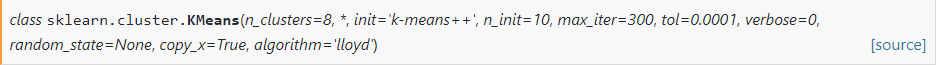

In [26]:
from sklearn.cluster import KMeans

#### Número de cluster

In [54]:
from sklearn.metrics import silhouette_score

varianza_intra_cluster = []
silhouettes = []
for k in range (1, 40):
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(doc_term_matrix_tfidf)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(doc_term_matrix_tfidf, kmeans.labels_)
    except:
        silhouette = 0 
    silhouettes.append(silhouette)

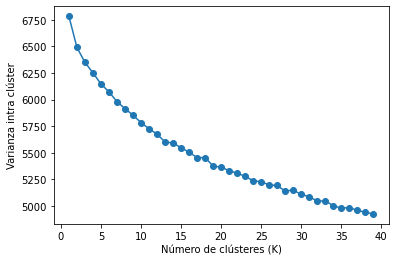

In [28]:
## Metodo del codo

plt.plot(range(1, 40), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

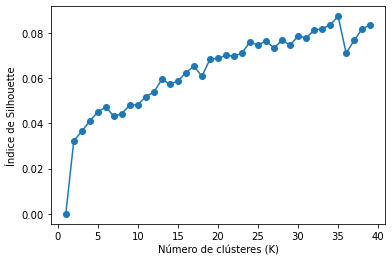

In [55]:
## Índice de Silhouette

plt.plot(range(1, 40), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.show()

In [63]:
### k medias
kmedias = KMeans(n_clusters = 6, random_state = 123).fit(doc_term_matrix_tfidf)

In [64]:
base["clasificacion"]=kmedias.labels_
base

motivo            medioingreso            momento  \
1     Queja                 Llamada    Antes del vuelo   
2     Queja                 Llamada   Durante el vuelo   
3     Queja                 Llamada  Después del vuelo   
4     Queja                 Digital    Antes del vuelo   
5     Queja                 Llamada  Después del vuelo   
...     ...                     ...                ...   
9993  Queja                 Digital    Antes del vuelo   
9994  Queja  Libro de reclamaciones    Antes del vuelo   
9995  Queja      Correo electrónico    Antes del vuelo   
9997  Queja                 Llamada  Después del vuelo   
9999  Queja      Correo electrónico  Después del vuelo   

                          razon  \
1     Irregularidad Operacional   
2     Servicios complementarios   
3     Irregularidad Operacional   
4           Consultas generales   
5       Irregularidad Equipajes   
...                         ...   
9993  Irregularidad Operacional   
9994  Irregularidad Operacional   
9995  Irregularidad Operacional   
9997    Irregularidad Equipajes   
9999    Irregularidad Equipajes   

                                            descripcion lang  \
1     pasajero solicita se le brinde nuevamente su n...   es   
2     nos contacta karla cruz para generar un reclam...   es   
3     se comunica el cliente para utilizar emd custo...   es   
4     el dia de hoy tenia un vuelo saliendo de la ci...   es   
5     se contacta la señora carmen, solicita verific...   es   
...                                                 ...  ...   
9993  reclamación previa a acciones legales caso 116...   es   
9994  pasajera afectada por la cancelación del vuelo...   es   
9995  compre un vuelo que salia a las 21.52 hrs desd...   es   
9997  se comunica la sra. ana maria calderon solicit...   es   
9999  se crea caso para dejar registro del saqueo,  ...   es   

                                     descripcion_limpia  \
1     pasajero solicita brinde nuevamente numero com...   
2     contacta karla cruz generar reclamo pasajero j...   
3     comunica cliente utilizar customer service com...   
4     tenia vuelo saliendo ciudad monteria ddestino ...   
5     contacta senora carmen solicita verificar caso...   
...                                                 ...   
9993           reclamacion previa acciones legales caso   
9994  pasajera afectada cancelacion vuelo debido cli...   
9995  compre vuelo salia bogota chile adquirir ticke...   
9997  comunica maria calderon solicitando informacio...   
9999    crea caso dejar registro saqueo maneja radicado   

                                                    tkn  \
1     [pasajero, solicita, brinde, nuevamente, numer...   
2     [contacta, karla, cruz, generar, reclamo, pasa...   
3     [comunica, cliente, utilizar, customer, servic...   
4     [tenia, vuelo, saliendo, ciudad, monteria, dde...   
5     [contacta, senora, carmen, solicita, verificar...   
...                                                 ...   
9993     [reclamacion, previa, acciones, legales, caso]   
9994  [pasajera, afectada, cancelacion, vuelo, debid...   
9995  [compre, vuelo, salia, bogota, chile, adquirir...   
9997  [comunica, maria, calderon, solicitando, infor...   
9999  [crea, caso, dejar, registro, saqueo, maneja, ...   

                                                  lemma  \
1     [pasajero, solicitar, brindir, nuevamente, num...   
2     [contactar, karlo, cruz, generar, reclamo, pas...   
3     [comunicar, cliente, utilizar, customer, servi...   
4     [tener, vuelo, salir, ciudad, monterio, ddesti...   
5     [contactar, senora, carmen, solicitar, verific...   
...                                                 ...   
9993         [reclamacion, previo, acción, legal, caso]   
9994  [pasajero, afectado, cancelacion, vuelo, debid...   
9995  [comprar, vuelo, salir, bogota, chile, adquiri...   
9997  [comunicar, maria, calderon, solicitar, inform...   
9999  [creer, caso, dejar, registro, saqueo, maneja

### Primer cluster

In [32]:
cluster_0 = base[base['clasificacion'] == 0]
cluster_0

motivo        medioingreso             momento  \
205   Queja             Llamada   Después del vuelo   
225   Queja  Correo electrónico     Antes del vuelo   
230   Queja  Correo electrónico  Reservas y compras   
254   Queja  Correo electrónico     Antes del vuelo   
264   Queja             Digital   Después del vuelo   
...     ...                 ...                 ...   
9925  Queja             Llamada   Después del vuelo   
9945  Queja             Digital     Antes del vuelo   
9980  Queja             Llamada   Después del vuelo   
9993  Queja             Digital     Antes del vuelo   
9999  Queja  Correo electrónico   Después del vuelo   

                          razon  \
205                   Reembolso   
225   Irregularidad Operacional   
230           Gestión de compra   
254   Irregularidad Operacional   
264     Irregularidad Equipajes   
...                         ...   
9925    Irregularidad Equipajes   
9945  Irregularidad Operacional   
9980    Irregularidad Equipajes   
9993  Irregularidad Operacional   
9999    Irregularidad Equipajes   

                                            descripcion lang  \
205   srta. cruz se comunica para saber si ya le bri...   es   
225   se crea caso para envio de compensación ya que...   es   
230   se crea caso de continuidad ya que analista la...   es   
254   se crea caso de continuidad para radicado 1901...   es   
264   se crea caso por daño en ajes  y saqueo, se ma...   es   
...                                                 ...  ...   
9925  se crea caso por saqueo para dejar registro (s...   es   
9945  ver documento adjunto\n**caso relacionado: 181...   es   
9980  se abre caso de continuidad de segunda búsqued...   es   
9993  reclamación previa a acciones legales caso 116...   es   
9999  se crea caso para dejar registro del saqueo,  ...   es   

                                     descripcion_limpia  \
205   srta cruz comunica saber brindaron respuesta c...   
225    crea caso envio compensacion analista tranfieren   
230           crea caso continuidad analista tranfieren   
254     crea caso continuidad radicado manejo respuesta   
264    crea caso dano ajes saqueo maneja caso principal   
...                                                 ...   
9925  crea caso saqueo dejar registro saqueo extempo...   
9945  documento adjunto caso relacionado crea caso b...   
9980  abre caso continuidad segunda busqueda asignac...   
9993           reclamacion previa acciones legales caso   
9999    crea caso dejar registro saqueo maneja radicado   

                                                    tkn  \
205   [srta, cruz, comunica, saber, brindaron, respu...   
225   [crea, caso, envio, compensacion, analista, tr...   
230     [crea, caso, continuidad, analista, tranfieren]   
254   [crea, caso, continuidad, radicado, manejo, re...   
264   [crea, caso, dano, ajes, saqueo, maneja, caso,...   
...                                                 ...   
9925  [crea, caso, saqueo, dejar, registro, saqueo, ...   
9945  [documento, adjunto, caso, relacionado, crea, ...   
9980  [abre, caso, continuidad, segunda, busqueda, a...   
9993     [reclamacion, previa, acciones, legales, caso]   
9999  [crea, caso, dejar, registro, saqueo, maneja, ...   

                                                  lemma  \
205   [srto, cruz, comunicar, saber, brindar, respue...   
225   [creer, caso, enviar, compensacion, analista, ...   
230    [creer, caso, continuidad, analista, tranfieren]   
254   [creer, caso, continuidad, radicado, manejo, r...   
264   [creer, caso, dano, aje, saqueo, manejar, caso...   
...                                                 ...   
9925  [creer, caso, saqueo, dejar, registro, saqueo,...   
9945  [documento, adjunto, caso, relacionado, creer,...   
9980  [abrir, caso, continuidad, segundo, busqueda, ...   
9993         [reclamacion, previo, acción, legal, caso]   
9999  [creer, caso, dejar, registro, saqueo, manejar...   

                           

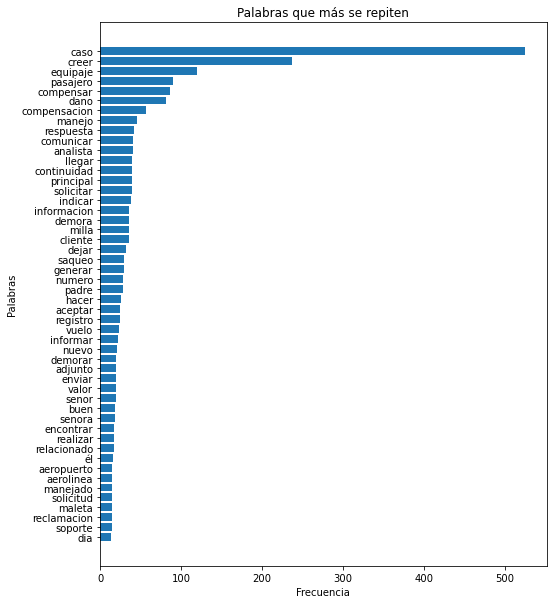

In [33]:
# Palabras que más se repiten
from collections import Counter

corpus=[]
new=cluster_0['lemma_str'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word,count in most[:50]:
    
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras que más se repiten')
plt.show()


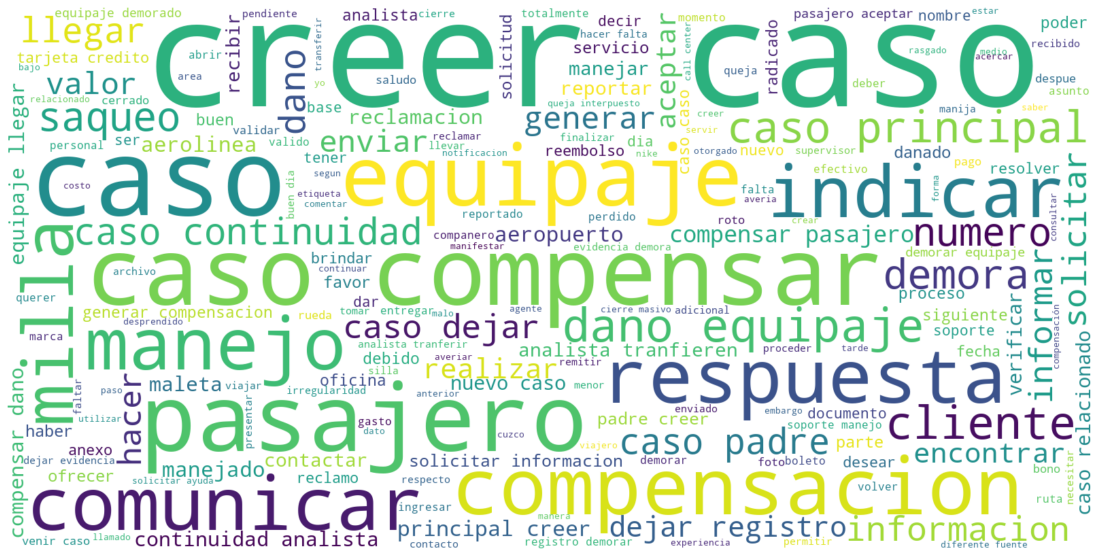

In [34]:
from wordcloud import WordCloud

text = " ".join(cluster_0['lemma_str'])

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Este grupo de quejas se refiere a manifestaciones de inconformidades por diferentes asuntos: Irregularidades operaciones, cancelacion, daño, demora

### Segundo cluster

In [35]:
cluster_1 = base[base['clasificacion'] == 1]
cluster_1

motivo            medioingreso             momento  \
29    Queja     Hoja de inquietudes     Antes del vuelo   
75    Queja                 Llamada   Después del vuelo   
96    Queja                 Llamada   Después del vuelo   
111   Queja                 Llamada   Después del vuelo   
117   Queja                 Llamada   Después del vuelo   
...     ...                     ...                 ...   
9879  Queja      Correo electrónico     Antes del vuelo   
9893  Queja                 Llamada  Reservas y compras   
9903  Queja  Libro de reclamaciones     Antes del vuelo   
9917  Queja                 Llamada   Después del vuelo   
9955  Queja     Hoja de inquietudes     Antes del vuelo   

                          razon  \
29    Irregularidad Operacional   
75      Irregularidad Equipajes   
96      Irregularidad Equipajes   
111     Irregularidad Equipajes   
117     Irregularidad Equipajes   
...                         ...   
9879  Irregularidad Operacional   
9893          Gestión de compra   
9903  Irregularidad Operacional   
9917    Irregularidad Equipajes   
9955  Irregularidad Operacional   

                                            descripcion lang  \
29    pasjaeros inconformes por demora de vuelo zz07...   es   
75    se comunica señor luzmila marin rios , consult...   es   
96    se comunica señor frank , consultando por su e...   es   
111   se comunica señora rosa, consultando por su eq...   es   
117   se comunica señor juan , consultando por su eq...   es   
...                                                 ...  ...   
9879  demora del vuelo zz09 / 15 noviembre en la rut...   es   
9893      compra de boleto en la ruta valledupar bogota   es   
9903  cliente hace reclamación por cancelación vuelo...   es   
9917  se comunica señor francisco , consultando por ...   es   
9955  cliente hace reclamación por cancelación de vu...   es   

                                     descripcion_limpia  \
29    pasjaeros inconformes demora vuelo noviembre d...   
75    comunica senor luzmila marin rios consultando ...   
96    comunica senor frank consultando equipaje demo...   
111   comunica senora rosa consultando equipaje demo...   
117   comunica senor juan consultando equipaje demor...   
...                                                 ...   
9879       demora vuelo noviembre ruta barcelona bogota   
9893               compra boleto ruta valledupar bogota   
9903    cliente hace reclamacion cancelacion vuelo ruta   
9917  comunica senor francisco consultando equipaje ...   
9955  cliente hace reclamacion cancelacion vuelo rut...   

                                                    tkn  \
29    [pasjaeros, inconformes, demora, vuelo, noviem...   
75    [comunica, senor, luzmila, marin, rios, consul...   
96    [comunica, senor, frank, consultando, equipaje...   
111   [comunica, senora, rosa, consultando, equipaje...   
117   [comunica, senor, juan, consultando, equipaje,...   
...                                                 ...   
9879  [demora, vuelo, noviembre, ruta, barcelona, bo...   
9893         [compra, boleto, ruta, valledupar, bogota]   
9903  [cliente, hace, reclamacion, cancelacion, vuel...   
9917  [comunica, senor, francisco, consultando, equi...   
9955  [cliente, hace, reclamacion, cancelacion, vuel...   

                                                  lemma  \
29    [pasjaero, inconforme, demorar, vuelo, noviemb...   
75    [comunicar, senor, luzmila, marin, rio, consul...   
96    [comunicar, senor, frank, consultar, equipaje,...   
111   [comunicar, senora, rosa, consultar, equipaje,...   
117   [comunicar, senor, juan, consultar, equipaje, ...   
...                                                 ...   
9879  [demorar, vuelo, noviembre, ruta, barcelono, b...   
9893         [compra, boleto, ruta, valledupar, bogoto]   
9903  [cliente, hacer, reclamacion, cancelacion, vue...   
9917  [comunicar, senor, francisco, consultar, equip...   
9955  [cliente, hacer, reclamacion, can

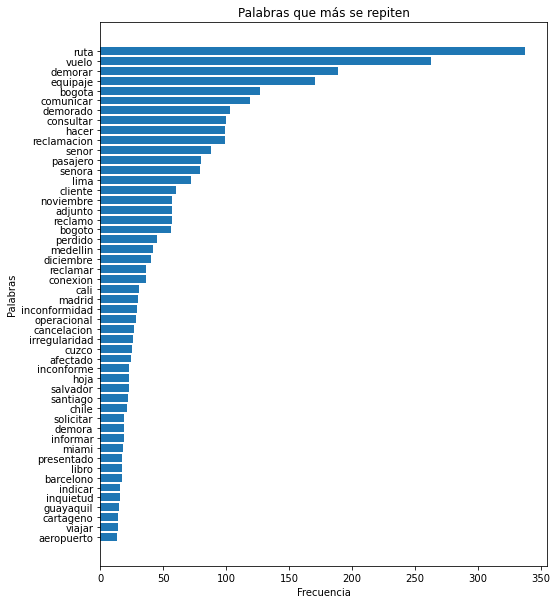

In [36]:
# Palabras que más se repiten
from collections import Counter

corpus=[]
new=cluster_1['lemma_str'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word,count in most[:50]:
    
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras que más se repiten')
plt.show()

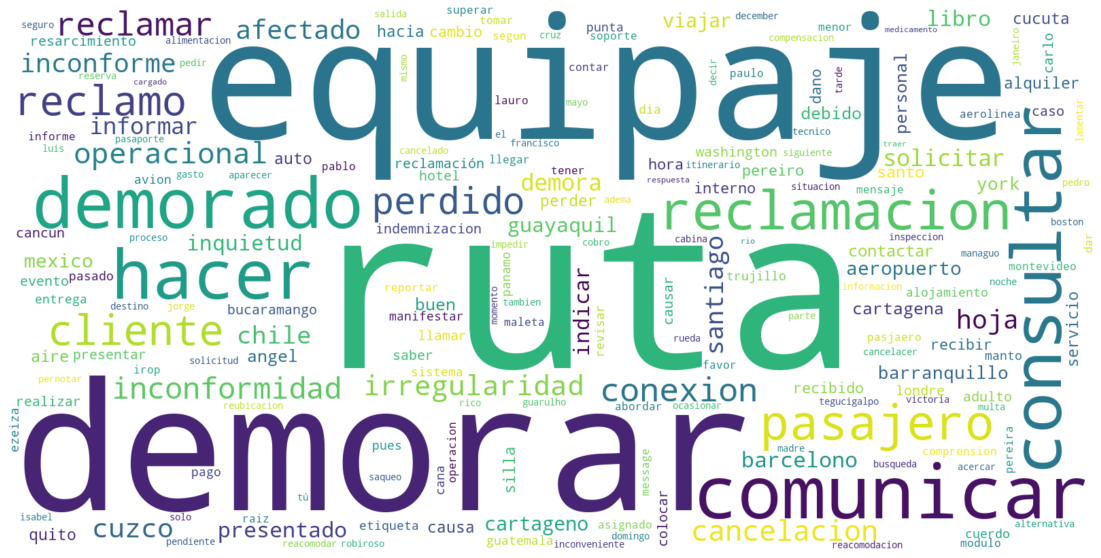

In [37]:
text = " ".join(cluster_1['lemma_str'])

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,collocations=False,
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Este grupo de quejas se refiere a la solicitud de compensaciones por:saqueo, daño de equipaje, demoras

### Tercer cluster

In [38]:
cluster_2 = base[base['clasificacion'] == 2]
cluster_2

motivo medioingreso            momento                    razon  \
9     Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
14    Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
22    Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
27    Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
32    Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
...     ...          ...                ...                      ...   
9944  Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
9963  Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
9977  Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
9992  Queja      Llamada  Después del vuelo  Irregularidad Equipajes   
9997  Queja      Llamada  Después del vuelo  Irregularidad Equipajes   

                                            descripcion lang  \
9     nos llama pasajero. para solicitar informacion...   es   
14    se comunica sr. moncayo solicita información d...   es   
22    se comunica sr. rodréguez solicita información...   es   
27    se contacta pasajero solicitando información s...   es   
32    pasajera solicita informacion de equipaje demo...   es   
...                                                 ...  ...   
9944  llama pasajera para saber el estado del equipa...   es   
9963  llama pasajera solicita información del equipaje.   es   
9977  se comunica el sr. edgar fabian gil solicitand...   es   
9992  se comunica alfonso , solicitando información ...   es   
9997  se comunica la sra. ana maria calderon solicit...   es   

                                     descripcion_limpia  \
9     llama pasajero solicitar informacion demora eq...   
14    comunica moncayo solicita informacion equipaje...   
22    comunica rodreguez solicita informacion equipa...   
27    contacta pasajero solicitando informacion demo...   
32    pasajera solicita informacion equipaje demorad...   
...                                                 ...   
9944               llama pasajera saber equipaje demora   
9963       llama pasajera solicita informacion equipaje   
9977  comunica edgar fabian solicitando informacion ...   
9992  comunica alfonso solicitando informacion demor...   
9997  comunica maria calderon solicitando informacio...   

                                                    tkn  \
9     [llama, pasajero, solicitar, informacion, demo...   
14    [comunica, moncayo, solicita, informacion, equ...   
22    [comunica, rodreguez, solicita, informacion, e...   
27    [contacta, pasajero, solicitando, informacion,...   
32    [pasajera, solicita, informacion, equipaje, de...   
...                                                 ...   
9944         [llama, pasajera, saber, equipaje, demora]   
9963  [llama, pasajera, solicita, informacion, equip...   
9977  [comunica, edgar, fabian, solicitando, informa...   
9992  [comunica, alfonso, solicitando, informacion, ...   
9997  [comunica, maria, calderon, solicitando, infor...   

                                                  lemma  \
9     [llamar, pasajero, solicitar, informacion, dem...   
14    [comunicar, moncayo, solicitar, informacion, e...   
22    [comunicar, rodreguez, solicitar, informacion,...   
27    [contactar, pasajero, solicitar, informacion, ...   
32    [pasajero, solicitar, informacion, equipaje, d...   
...                                                 ...   
9944        [llamar, pasajero, saber, equipaje, demora]   
9963  [llamar, pasajero, solicitar, informacion, equ...   
9977  [comunicar, edgar, fabian, solicitar, informac...   
9992  [comunicar, alfonso, solicitar, informacion, d...   
9997  [comunicar, maria, calderon, solicitar, inform...   

                                              lemma_str  clasificacion  
9     llamar pasajero solicitar informacion demora e...              2  
14    comunicar moncayo solicitar informacion equipa...              2  
22    comunicar rodreguez

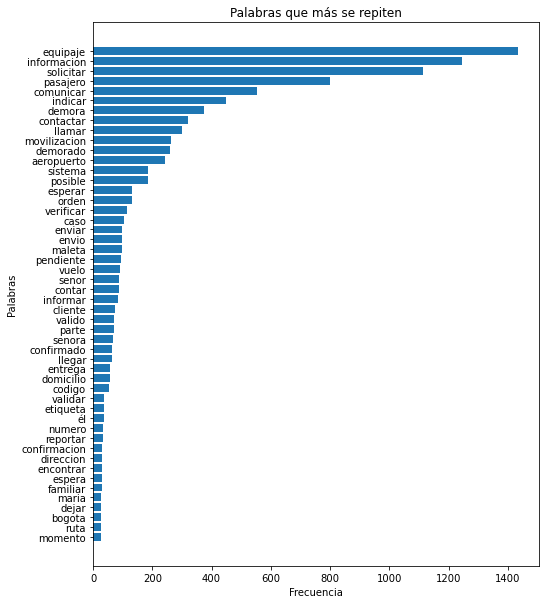

In [39]:
# Palabras que más se repiten
from collections import Counter

corpus=[]
new=cluster_2['lemma_str'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word,count in most[:50]:
    
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras que más se repiten')
plt.show()

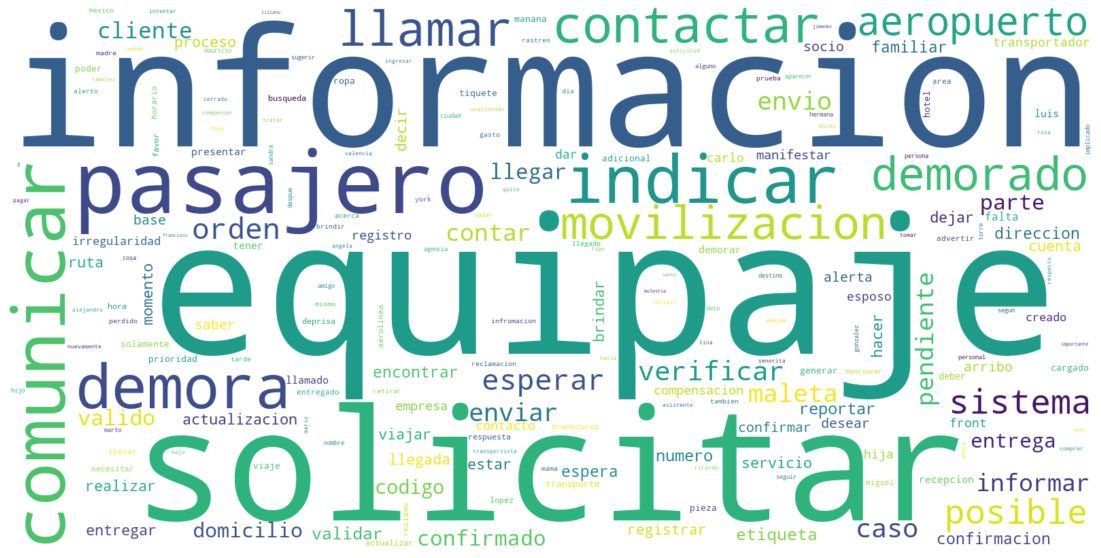

In [40]:
text = " ".join(cluster_2['lemma_str'])

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,collocations=False,
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Este grupo de quejas se refiere a informacion sobre demora de equipaje y ruta

### Cuarto cluster

In [41]:
cluster_3 = base[base['clasificacion'] == 3]
cluster_3

motivo        medioingreso            momento                      razon  \
1     Queja             Llamada    Antes del vuelo  Irregularidad Operacional   
17    Queja             Digital  Después del vuelo  Irregularidad Operacional   
34    Queja             Llamada  Después del vuelo  Irregularidad Operacional   
37    Queja      Correo interno    Antes del vuelo  Irregularidad Operacional   
40    Queja             Llamada  Después del vuelo  Irregularidad Operacional   
...     ...                 ...                ...                        ...   
9937  Queja             Llamada  Después del vuelo  Irregularidad Operacional   
9940  Queja             Llamada  Después del vuelo  Irregularidad Operacional   
9950  Queja  Correo electrónico    Antes del vuelo  Irregularidad Operacional   
9953  Queja             Llamada  Después del vuelo  Irregularidad Operacional   
9973  Queja             Llamada    Antes del vuelo  Irregularidad Operacional   

                                            descripcion lang  \
1     pasajero solicita se le brinde nuevamente su n...   es   
17    buenos días,\nnos gustaría poner una reclamaci...   es   
34    se comunica sra. ana sierra por compensación n...   es   
37    buenos días\n\n\nestimados su ayuda por favor ...   es   
40    se comunica pasajera, indicando que el día 13 ...   es   
...                                                 ...  ...   
9937  daniel cuellar solicitando compensaciones que ...   es   
9940  pasajero indica que el dia 13/01/2018 tenia su...   es   
9950  pasajera solicita compensacion por la demora d...   es   
9953  pasajero se comunica porque realizo un viaje e...   es   
9973  señor juan llama para verificar si existe comp...   es   

                                     descripcion_limpia  \
1     pasajero solicita brinde nuevamente numero com...   
17    buenos dias gustaria poner reclamacion senor t...   
34    comunica sierra compensacion recibida cambio v...   
37    buenos dias estimados ayuda favor contactando ...   
40    comunica pasajera indicando diciembre ruta bog...   
...                                                 ...   
9937  daniel cuellar solicitando compensaciones novi...   
9940  pasajero indica tenia vuelo programado ruta es...   
9950  pasajera solicita compensacion demora vuelo oc...   
9953  pasajero comunica realizo viaje ruta bogota an...   
9973  senor juan llama verificar existe compensacion...   

                                                    tkn  \
1     [pasajero, solicita, brinde, nuevamente, numer...   
17    [buenos, dias, gustaria, poner, reclamacion, s...   
34    [comunica, sierra, compensacion, recibida, cam...   
37    [buenos, dias, estimados, ayuda, favor, contac...   
40    [comunica, pasajera, indicando, diciembre, rut...   
...                                                 ...   
9937  [daniel, cuellar, solicitando, compensaciones,...   
9940  [pasajero, indica, tenia, vuelo, programado, r...   
9950  [pasajera, solicita, compensacion, demora, vue...   
9953  [pasajero, comunica, realizo, viaje, ruta, bog...   
9973  [senor, juan, llama, verificar, existe, compen...   

                                                  lemma  \
1     [pasajero, solicitar, brindir, nuevamente, num...   
17    [buen, dia, gustar, poner, reclamacion, senor,...   
34    [comunicar, sierra, compensacion, recibido, ca...   
37    [buen, dia, estimado, ayudar, favor, contactar...   
40    [comunicar, pasajero, indicar, diciembre, ruta...   
...                                                 ...   
9937  [daniel, cuellar, solicitar, compensación, nov...   
9940  [pasajero, indicar, tener, vuelo, programado, ...   
9950  [pasajero, solicitar, compensacion, demora, vu...   
9953  [pasajero, comunicar, realizar, viaje, ruta, b...   
9973  [senor, juan, llamar, verificar, existir, comp...   

                                              lemma_str  clasificacion  
1     pasajero solicitar brindir nuevamente numero c...        

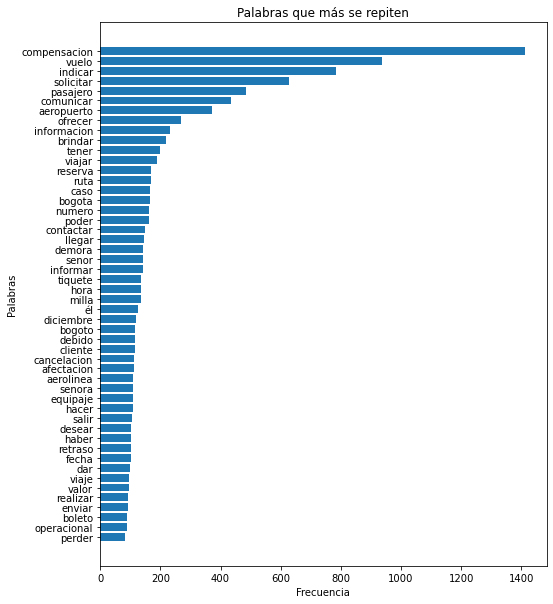

In [42]:
# Palabras que más se repiten
from collections import Counter

corpus=[]
new=cluster_3['lemma_str'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word,count in most[:50]:
    
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras que más se repiten')
plt.show()

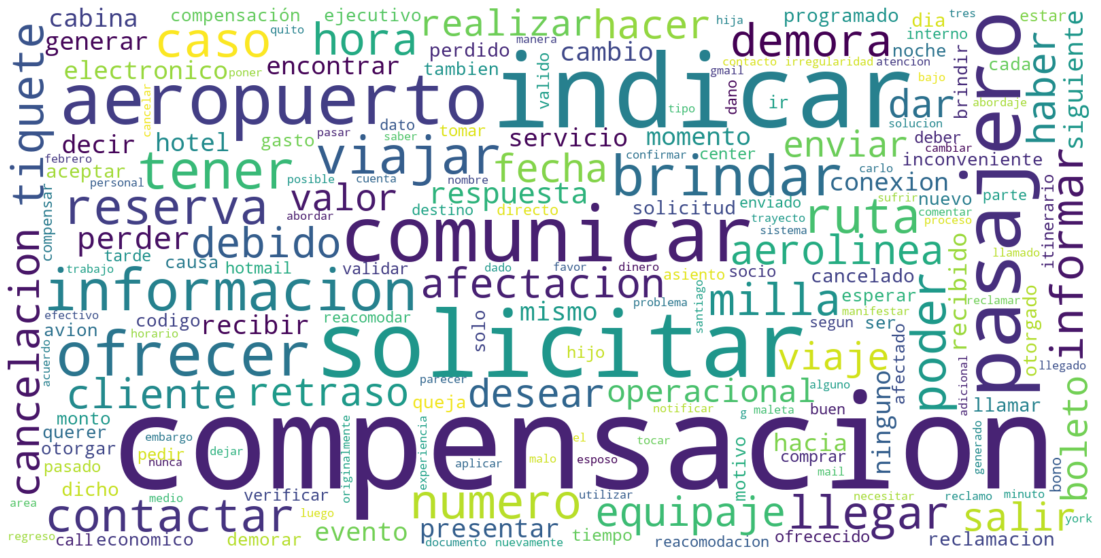

In [43]:
text = " ".join(cluster_3['lemma_str'])

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,collocations=False,
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Quejas informando el estado del equipaje: Dañado y roto

### Quinto cluster

In [44]:
cluster_4 = base[base['clasificacion'] == 4]
cluster_4

motivo         medioingreso            momento                    razon  \
5     Queja              Llamada  Después del vuelo  Irregularidad Equipajes   
10    Queja                  PIR  Después del vuelo  Irregularidad Equipajes   
26    Queja              Llamada  Después del vuelo  Irregularidad Equipajes   
33    Queja              Digital  Después del vuelo  Irregularidad Equipajes   
46    Queja              Llamada  Después del vuelo  Irregularidad Equipajes   
...     ...                  ...                ...                      ...   
9967  Queja  Hoja de inquietudes  Después del vuelo  Irregularidad Equipajes   
9975  Queja              Llamada  Después del vuelo  Irregularidad Equipajes   
9978  Queja              Llamada  Después del vuelo  Irregularidad Equipajes   
9981  Queja              Llamada  Después del vuelo  Irregularidad Equipajes   
9990  Queja              Digital  Después del vuelo  Irregularidad Equipajes   

                                            descripcion lang  \
5     se contacta la señora carmen, solicita verific...   es   
10    aje llega rasgado o mas bien cortado como con ...   es   
26    se comunica socio solicitando información de s...   es   
33    estoy a la eso espera de una maleta que no lle...   es   
46    pasajero llama indicando que el día de ayer 30...   es   
...                                                 ...  ...   
9967  pasajera llega del vuelo zz0282 procedente de ...   es   
9975  pasajero manifiesta que llegaron tanto él como...   es   
9978  se comunica la sra. victoria lucia navarro des...   es   
9981  se comunica pasajero indicando que la maleta l...   es   
9990  buenas tardes, el dia 06 de enero de 2019 en l...   es   

                                     descripcion_limpia  \
5     contacta senora carmen solicita verificar caso...   
10    llega rasgado bien cortado filo parte superior...   
26    comunica socio solicitando informacion maleta ...   
33    espera maleta llego avion recibido ninguna not...   
46    pasajero llama indicando ayer fuer retirar equ...   
...                                                 ...   
9967  pasajera llega vuelo procedente ibague informa...   
9975  pasajero manifiesta llegaron senor juan viajan...   
9978  comunica victoria lucia navarro desea dejar re...   
9981  comunica pasajero indicando maleta llegaba aho...   
9990  buenas tardes   banda equipajes recibiendo mal...   

                                                    tkn  \
5     [contacta, senora, carmen, solicita, verificar...   
10    [llega, rasgado, bien, cortado, filo, parte, s...   
26    [comunica, socio, solicitando, informacion, ma...   
33    [espera, maleta, llego, avion, recibido, ningu...   
46    [pasajero, llama, indicando, ayer, fuer, retir...   
...                                                 ...   
9967  [pasajera, llega, vuelo, procedente, ibague, i...   
9975  [pasajero, manifiesta, llegaron, senor, juan, ...   
9978  [comunica, victoria, lucia, navarro, desea, de...   
9981  [comunica, pasajero, indicando, maleta, llegab...   
9990  [buenas, tardes, banda, equipajes, recibiendo,...   

                                                  lemma  \
5     [contactar, senora, carmen, solicitar, verific...   
10    [llegar, rasgado, bien, cortado, filo, parte, ...   
26    [comunicar, socio, solicitar, informacion, mal...   
33    [esperar, maleta, llegar, avion, recibido, nin...   
46    [pasajero, llamar, indicar, ayer, fuer, retira...   
...                                                 ...   
9967  [pasajero, llegar, vuelo, procedente, ibague, ...   
9975  [pasajero, manifestar, llegar, senor, juan, vi...   
9978  [comunicar, victoria, lucio, navarro, desear, ...   
9981  [comunicar, pasajero, indicar, maleta, llegar,...   
9990  [buen, tarde, banda, equipaje, recibir, maleta...   

                                              lemma_str  clasificacion  
5     contactar senora carmen solicitar verificar ca...              4  
10

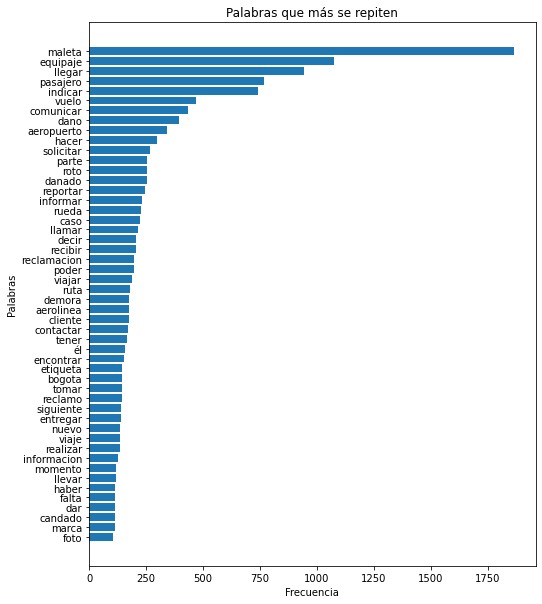

In [45]:
# Palabras que más se repiten
from collections import Counter

corpus=[]
new=cluster_4['lemma_str'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word,count in most[:50]:
    
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras que más se repiten')
plt.show()

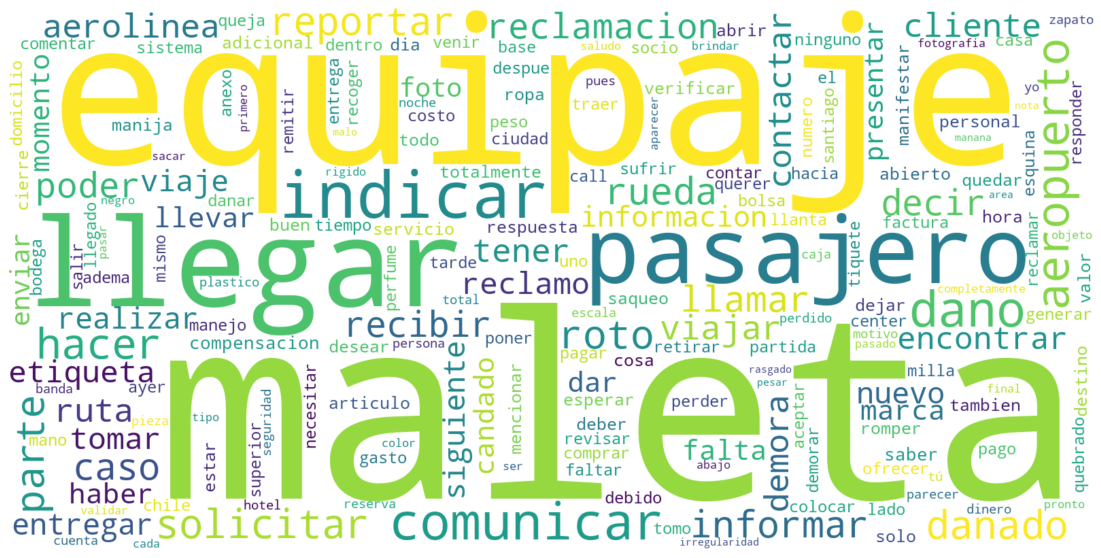

In [46]:
text = " ".join(cluster_4['lemma_str'])

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,collocations=False,
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Solicitar informacion sobre posible motivilzacion?

### Sexto cluster

In [47]:
cluster_5 = base[base['clasificacion'] == 5]
cluster_5

motivo            medioingreso             momento  \
2     Queja                 Llamada    Durante el vuelo   
3     Queja                 Llamada   Después del vuelo   
4     Queja                 Digital     Antes del vuelo   
8     Queja                     PIR   Después del vuelo   
11    Queja     Hoja de inquietudes     Antes del vuelo   
...     ...                     ...                 ...   
9982  Queja                 Llamada     Antes del vuelo   
9987  Queja      Correo electrónico   Después del vuelo   
9991  Queja                 Llamada  Reservas y compras   
9994  Queja  Libro de reclamaciones     Antes del vuelo   
9995  Queja      Correo electrónico     Antes del vuelo   

                          razon  \
2     Servicios complementarios   
3     Irregularidad Operacional   
4           Consultas generales   
8       Irregularidad Equipajes   
11    Irregularidad Operacional   
...                         ...   
9982                Exoneración   
9987  Irregularidad Operacional   
9991             Error en cobro   
9994  Irregularidad Operacional   
9995  Irregularidad Operacional   

                                            descripcion lang  \
2     nos contacta karla cruz para generar un reclam...   es   
3     se comunica el cliente para utilizar emd custo...   es   
4     el dia de hoy tenia un vuelo saliendo de la ci...   es   
8     pax presenta reclamación ya que tuvo que incur...   es   
11    pasajera inconforme por demora de vuelo zz09 c...   es   
...                                                 ...  ...   
9982  se comunica el sra. leidy velasquez se comunic...   es   
9987  buenas tardes.\n\nen el dia 27/11/18, yo desde...   es   
9991  se contacta el señor jonathan solicitando asis...   es   
9994  pasajera afectada por la cancelación del vuelo...   es   
9995  compre un vuelo que salia a las 21.52 hrs desd...   es   

                                     descripcion_limpia  \
2     contacta karla cruz generar reclamo pasajero j...   
3     comunica cliente utilizar customer service com...   
4     tenia vuelo saliendo ciudad monteria ddestino ...   
8     presenta reclamacion incurrir gastos debido eq...   
11    pasajera inconforme demora vuelo ruta barcelon...   
...                                                 ...   
9982  comunica leidy velasquez comunica tomar nuevo ...   
9987  buenas tardes cuenta redimi tiquete bogota pau...   
9991  contacta senor jonathan solicitando asistencia...   
9994  pasajera afectada cancelacion vuelo debido cli...   
9995  compre vuelo salia bogota chile adquirir ticke...   

                                                    tkn  \
2     [contacta, karla, cruz, generar, reclamo, pasa...   
3     [comunica, cliente, utilizar, customer, servic...   
4     [tenia, vuelo, saliendo, ciudad, monteria, dde...   
8     [presenta, reclamacion, incurrir, gastos, debi...   
11    [pasajera, inconforme, demora, vuelo, ruta, ba...   
...                                                 ...   
9982  [comunica, leidy, velasquez, comunica, tomar, ...   
9987  [buenas, tardes, cuenta, redimi, tiquete, bogo...   
9991  [contacta, senor, jonathan, solicitando, asist...   
9994  [pasajera, afectada, cancelacion, vuelo, debid...   
9995  [compre, vuelo, salia, bogota, chile, adquirir...   

                                                  lemma  \
2     [contactar, karlo, cruz, generar, reclamo, pas...   
3     [comunicar, cliente, utilizar, customer, servi...   
4     [tener, vuelo, salir, ciudad, monterio, ddesti...   
8     [presentar, reclamacion, incurrir, gasto, debi...   
11    [pasajero, inconforme, demora, vuelo, ruta, ba...   
...                                                 ...   
9982  [comunicar, leidy, velasquez, comunicar, tomar...   
9987  [buen, tarde, contar, redimi, tiquete, bogoto,...   
9991  [contactar, senor, jonathan, solicitar, asiste...   
9994  [pasajero, afectado, cancelacion, vuelo, debid...   
9995  [comprar, vuelo, salir, bogota, c

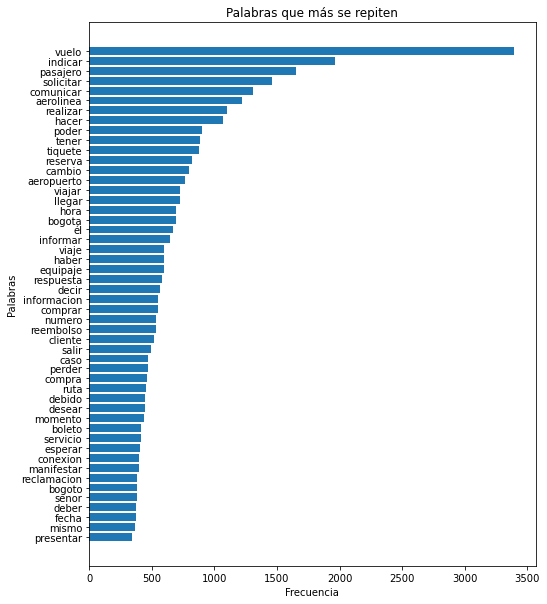

In [48]:
# Palabras que más se repiten
from collections import Counter

corpus=[]
new=cluster_5['lemma_str'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

counter=Counter(corpus)
most=counter.most_common()

x, y = [], []
for word,count in most[:50]:
    
    x.append(word)
    y.append(count)

plt.figure(figsize = (8, 10))
plt.barh(x, y)
plt.gca().invert_yaxis()
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Palabras que más se repiten')
plt.show()

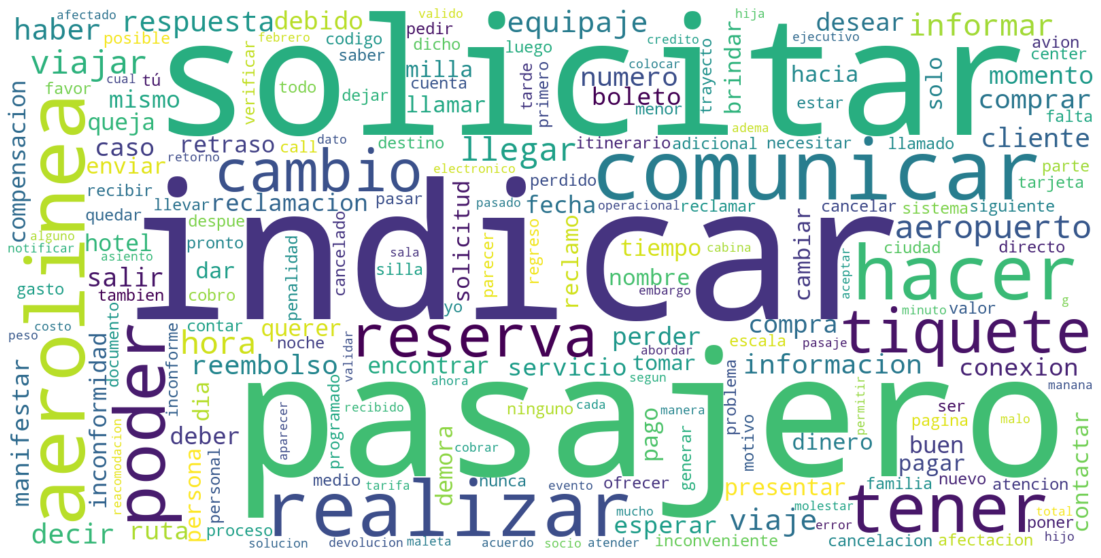

In [49]:
text = " ".join(cluster_5['lemma_str'])

# Armamos la nube de palabras
wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,collocations=False,
    background_color = "white").generate(text)
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

No hay claridad

In [58]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [65]:
k = 20
tfs_reduced = TruncatedSVD(n_components=k, random_state=0).fit_transform(doc_term_matrix_tfidf)

In [66]:
tfs_embedded = TSNE(n_components=2, perplexity=15).fit_transform(tfs_reduced)

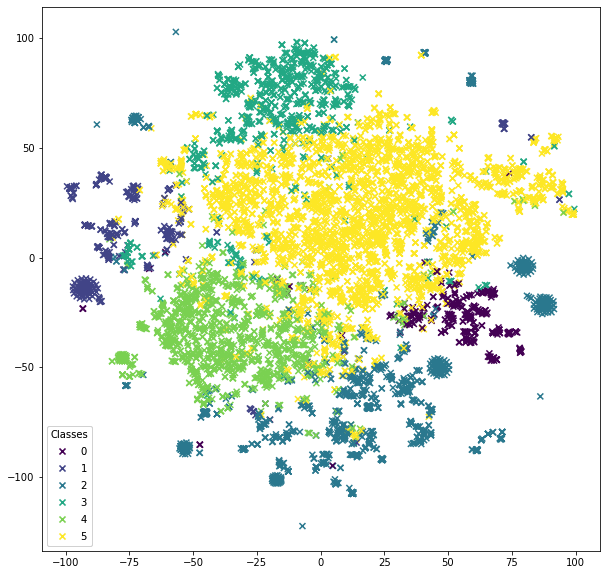

In [68]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
asd=plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x", c = kmedias.labels_)
legend1 = ax.legend(*asd.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

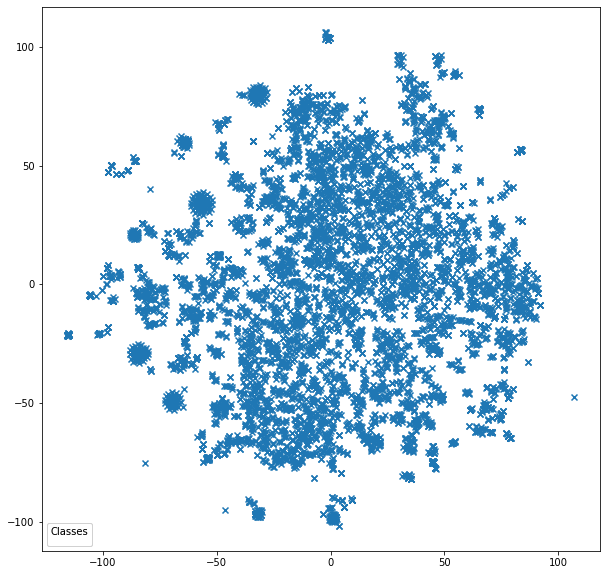

In [62]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
asd=plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x")
legend1 = ax.legend(*asd.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

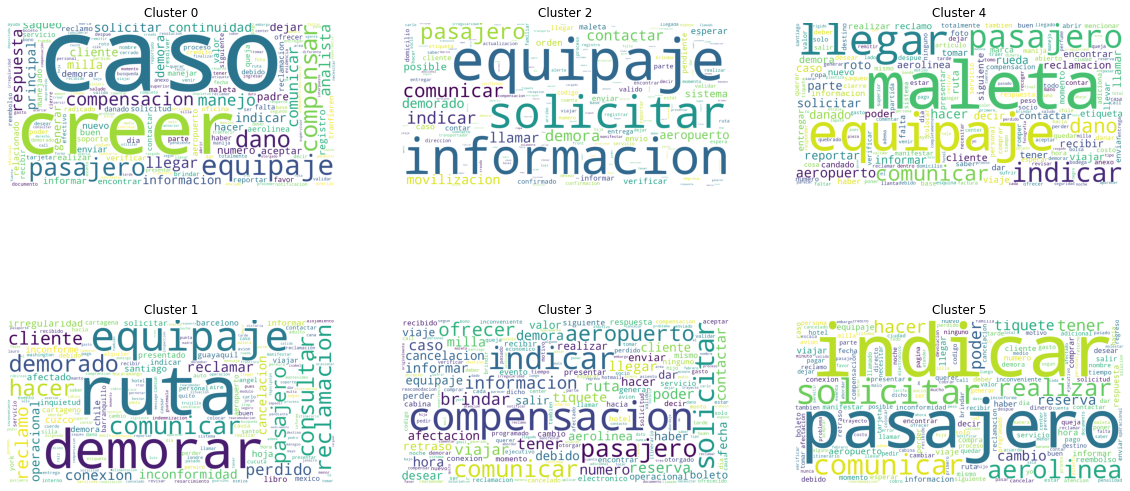

In [90]:
rows=2
cols=3

fig, ax = plt.subplots(rows, cols, figsize=(20,10))

row=0 
col=0 

for t in range(6):
    cluster_temp = base[base['clasificacion'] == t]
    text = " ".join(cluster_temp['lemma_str'])
    wordcloud = WordCloud(width = 1600, height = 800, stopwords = lista_palabras_vacias,collocations=False,
        background_color = "white").generate(text)
    ax[row][col].imshow(wordcloud)
    ax[row][col].axis('off')
    ax[row][col].set_title('Cluster '+str(t))
    row=row+1
    if row==rows:
        row=0
        col=col+1


#plt.savefig(f"terms_all.png", bbox_inches='tight')
    plt.grid(b=None)

plt.show()

In [96]:
base['clasificacion'].value_counts(normalize=True) * 100

5    44.275323
4    16.998922
2    16.958513
3    11.718750
1     5.522629
0     4.525862
Name: clasificacion, dtype: float64